In [1]:
import numpy as np
from numpy import linalg as LA
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
# import mymodule as myModules
import matplotlib.cm as cm
from scipy import linalg
from timeit import default_timer as timer
import networkx as nx
import os
import pickle
import datetime
#### Import SLOG packakes
from SLOGmodules import SLOGtools as SLOGtools
from SLOGmodules import SLOGobjective as SLOGobj
from SLOGmodules import SLOGarchitectures as SLOGarchi 
from SLOGmodules import SLOGtraining as SLOGtrainer
from SLOGmodules import SLOGmodel as SLOGmodel
from SLOGmodules import SLOGevaluation as SLOGevaluator
from SLOGmodules import SLOGdata as SLOGdata
from SLOGmodules import SLOGnoiseTest as SLOGnoiseTest

#### Import GNN packages
from SLOGmodules import graphTools as graphTools
from SLOGmodules import dataTools as dataTools

from alegnn.modules import architectures as archit
from alegnn.modules import model as model
from alegnn.modules import training as training
from alegnn.modules import evaluation as evaluation
from alegnn.modules import loss as loss
from alegnn.utils.miscTools import writeVarValues
from alegnn.utils.miscTools import saveSeed

### Import trained models
from SLOGTrainedModels import trainedModels as trainedModels

Model list

In [2]:
# saveDir_dropbox = '/Users/changye/Dropbox/onlineResults/experiments'
# saveDir_dropbox = r"C:\Users\Chang Ye\Dropbox\onlineResults\experiments"
saveDir_dropbox_root = '/Users/changye/Dropbox/onlineResults'
# saveDir_dropbox_root = r"C:\Users\Chang Ye\Dropbox\onlineResults"

saveDir_dropbox = os.path.join(saveDir_dropbox_root,'experiments')


### ER
nNodes = 20 # Number of nodes
P = 400
S = 3

nClasses = 3 # Number of classes (i.e. number of communities)
N_C = 3 # Number of sources per signal
alpha = 1.0

graphType = 'ER'
list_number = 3

# list_name = 'modelDirList_0' # Model v3,Train filter type = g (list_number = 3) q = 4
# list_name = 'modelDirList_1' # Model v1, Train filter type = g (list_number = 3)
# list_name = 'modelDirList_2' # Model v3,Train filter type = h (list_number = 3) q = 4
# list_name = 'modelDirList_3' # Model v3,Train filter type = g (list_number = 3) q = 10
# list_name = 'modelDirList_4' # Model v3,Train filter type = h (list_number = 3) q = 10
# list_name = 'modelDirList_5' # Model v1, Train filter type = h (list_number = 3)
# list_name = 'modelDirList_6' # Model v3,Train filter type = h (list_number = 3) q = 4, noise = 0.02
# list_name = 'modelDirList_7' # Model v3,Train filter type = h (list_number = 3) q = 4, noise = 0.05
# list_name = 'modelDirList_8' # Model v3,Train filter type = h (list_number = 3) q = 1, noise = 0.0
# list_name = 'modelDirList_9' # Model v3,Train filter type = h (list_number = 3) q = 20, noise = 0.0
# list_name = 'modelDirList_10' # Model v3,Train filter type = h (list_number = 3) q = 2, noise = 0.0



## Model number: 0, SLOG-Net_v1; 1, SLOG-Net_v3
model_number = 1
# model_number = 0
q = 4
# q = 20
# q = 10
# q = 1
# q = 2




model_list = trainedModels.get_modelList(graphType, list_number)


modelDirList = model_list[list_name]
# modelDirList = model_list['modelDirList_1']
# modelDirList = model_list['modelDirList_2']

print(model_list[list_name+'_label'])
## 
normalize_g_hat = True # Normalize g_hat to sum = nNodes. suggest nnly mormalize g_hat for 'ER' list 1
# normalize_g_hat = False 

['Noise level 0, SLOG-net v3, q = 2, trainmode = h']


Parameters

In [3]:
### Model parameters
K = 5 # number of layers
# C = 1 # constrain constant
C = nNodes # constrain constant
# filterTrainType = 'g'
filterTrainType = 'h'
### Simulation parameters
simuParas = {}
# location = 'home'
location = 'office'
nTrain_slog = 100000
batchsize_slog = 400
nValid = batchsize_slog
nTest = batchsize_slog
nEpochs = 50
N_realiz = 500
### Data parameters
L = 5
alpha = 1.0
N_noiseLvs = 10
d_noiseLvs = 0.01
n0 = 0


### Graph parameters


simuParas['nNodes'] = nNodes
simuParas['nClasses'] = nClasses
simuParas['N_C'] = N_C

# graphType = 'SBM' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['nCommunities'] = nClasses # Number of communities
# graphOptions['probIntra'] = 0.8 # Probability of drawing edges intra communities
# graphOptions['probInter'] = 0.2 # Probability of drawing edges inter communities


# graphType = 'BA' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['alpha'] = 1.0

graphType = 'ER' # Type of graph
graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
graphOptions['probIntra'] = 0.3 # Probability of drawing edges

simuParas['graphType'] = graphType
simuParas['graphOptions'] = graphOptions

## Filter type: g or h
# filterType = 'g'
filterType = 'h'

## Signal mode: gaussion or 1
signalMode = 'Gaussion'

## Train mode: Wt or default (Vdiag(\tilde{h})V^T)
trainMode = 'default'
# trainMode = 'Wt'

## Filter mode: Wt or default (Vdiag(\tilde{h})V^T)
filterMode = 'default'
# filterMode = 'Wt'

## Selection mode: random or nodes with top-N_C degree
selectMode = 'random'

## Noise level
noiseLevel = 0.0
noiseType = 'uniform'

simuParas['nTrain_slog'] = nTrain_slog
simuParas['batchsize_slog'] = batchsize_slog
simuParas['nValid'] = nValid
simuParas['nTest'] = nTest
simuParas['L'] = L
simuParas['noiseLevel'] = noiseLevel
simuParas['noiseType'] = noiseType
simuParas['filterType'] = filterType
simuParas['signalMode'] = signalMode
simuParas['trainMode'] = trainMode
simuParas['filterMode'] = filterMode
simuParas['selectMode'] = selectMode
simuParas['graphType'] = graphType 
simuParas['alpha'] = alpha
simuParas['nEpochs'] = nEpochs
simuParas['C'] =  C
simuParas['K'] =  K
simuParas['N_realiz'] =  N_realiz
simuParas['model_number'] = model_number
modelParas = {}
modelParas['q'] = q

tMax = None # Maximum number of diffusion times (W^t for t < tMax)
tMax = 3
simuParas['tMax'] = tMax





In [4]:
## Experiment results
# modelDirList = modelDirList_0
# modelDirList = modelDirList_1

N_model = len(modelDirList)
noiseLvs = n0 + d_noiseLvs*np.arange(N_noiseLvs)
result_exp_rex = np.zeros([N_noiseLvs, N_model,N_realiz])
result_exp_reg = np.zeros([N_noiseLvs, N_model,N_realiz])
n_model = 0
for modelDir in modelDirList:
    for n_nlvs in range(N_noiseLvs):
        simuParas['noiseLevel'] = noiseLvs[n_nlvs]        
        print('Model ', n_model, ', in ', modelDir,',noiseLevel = ', noiseLvs[n_nlvs])
        result = SLOGnoiseTest.noiseTest_dropbox(nNodes,P,S, modelDir, simuParas = simuParas,modelParas = modelParas, location = location , normalize_g_hat = normalize_g_hat)
        result_exp_rex[n_nlvs,n_model,:] = result['re_x']
        result_exp_reg[n_nlvs,n_model,:] = result['re_g']  
    n_model += 1

Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.0
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.01
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.02
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.03
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.04
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.05
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.06
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.07
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.08
Running test at  office
Model  0 , in  sourceLocSLOGNET-ER-20220706175730 ,noiseLevel =  0.09
Running test at  office
Model  1 , in  sourceLocSLOGNET-ER-20220706191146 ,noiseLevel

/Users/changye/github/slog-net/slog-net-master/graph-neural-networks-master/SLOGmodules/SLOGnoiseTest.py:259: RuntimeWarning: invalid value encountered in true_divide
  g_hat = nNodes*g_hat/np.sum(g_hat)


Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.01
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.02
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.03
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.04
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.05
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.06
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.07
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.08
Running test at  office
Model  7 , in  sourceLocSLOGNET-ER-20220707030002 ,noiseLevel =  0.09
Running test at  office
Model  8 , in  sourceLocSLOGNET-ER-20220707042750 ,noiseLevel =  0.0
Running test at  office
Model  8 , in  sourceLocSLOGNET-ER-20220707042750 ,noiseLevel

SLOG-Net Model

In [5]:
# print(result_exp_rex.shape)
print(result_exp_reg)
# print(simuParas)
print(modelDir)

[[[0.09969702 0.08468944 0.23057422 ... 0.53707967 0.06807949 0.08720243]
  [0.21032976 0.10805853 0.26287876 ... 0.10242126 0.77437987 0.56655387]
  [0.00875207 0.05328958 0.00753393 ... 0.00797688 0.00840639 0.00402408]
  ...
  [       nan        nan        nan ...        nan        nan        nan]
  [0.01649957 0.06942862 0.02900511 ... 0.03271621 0.01868117 0.01992408]
  [0.07880694 0.039652   0.04783409 ... 0.06220415 0.02941778 0.07099696]]

 [[0.15067971 0.08575684 0.05062073 ... 0.07205684 0.10844659 0.84555675]
  [0.12953959 1.73456373 0.0966257  ... 0.08782247 0.06589113 0.08692554]
  [0.01350522 0.17185906 0.01569872 ... 0.00823614 0.00966234 0.00968359]
  ...
  [       nan        nan        nan ...        nan        nan        nan]
  [0.02231479 0.01587141 0.02111508 ... 0.02687033 0.03698069 0.01913856]
  [0.07075011 0.04048886 0.78088301 ... 0.04814923 0.08385124 0.04794573]]

 [[0.0435321  0.39365875 0.18988522 ... 0.05396551 0.1164892  0.45085939]
  [0.07594907 0.155625

Mean relative error for noise level

(10, 6, 500)
(10, 6)
(10,)


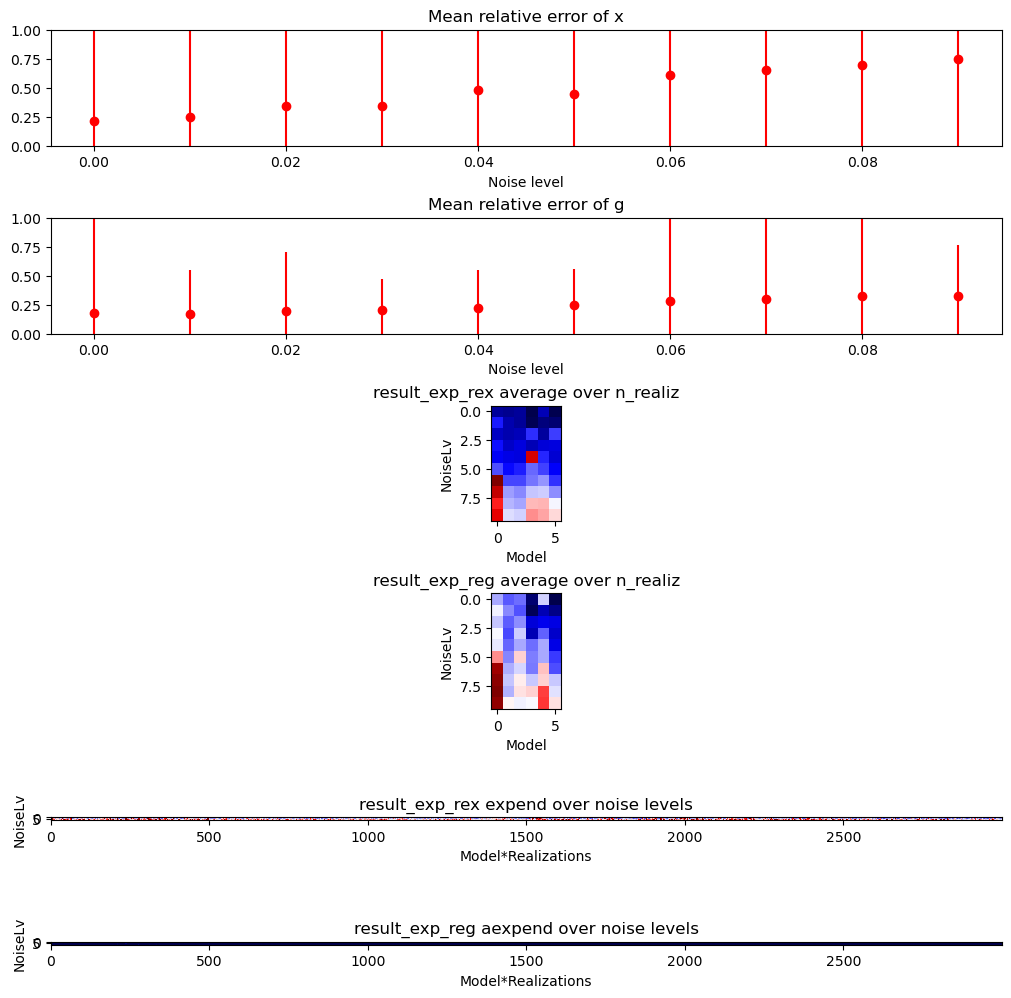

In [23]:
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
model = 0

# model_index = [0,1,2,3,4,5,6,7,8,9]
model_index = [0,1,4,5,6,8]
# N_noiseLvIndex = len(noiseLv_index)
N_model_1 = len(model_index)
result_exp_rex_1 = result_exp_rex[:,model_index,:]
result_exp_reg_1 = result_exp_reg[:,model_index,:]
# result_exp_rex_1 = result_exp_rex_1[noiseLv_index,:,:]
# result_exp_reg_1 = result_exp_reg_1[noiseLv_index,:,:]

# result_exp_rex_1 = result_exp_rex[:,:,:]
# result_exp_reg_1 = result_exp_reg[:,:,:]
N_noiseLvIndex = N_noiseLvs

print(result_exp_rex_1.shape)
# re_x_avg = np.mean(np.mean(result_exp_rex_1, axis=2), axis=1)
# re_g_avg = np.mean(np.mean(result_exp_reg_1, axis=2), axis=1)
re_x_avg = np.mean(result_exp_rex_1.reshape((N_noiseLvs,N_model_1*N_realiz)), axis=1)
re_g_avg = np.mean(result_exp_reg_1.reshape((N_noiseLvs,N_model_1*N_realiz)), axis=1)
re_x_std = np.std(result_exp_rex_1.reshape((N_noiseLvs,N_model_1*N_realiz)), axis=1)
re_g_std = np.std(result_exp_reg_1.reshape((N_noiseLvs,N_model_1*N_realiz)), axis=1)
result_exp_rex_reshape = result_exp_rex_1.reshape((N_noiseLvs,N_model_1*N_realiz))
result_exp_reg_reshape = result_exp_reg_1.reshape((N_noiseLvs,N_model_1*N_realiz))

print(np.mean(result_exp_rex_1, axis=2).shape)
print(re_x_avg.shape)
fig, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True,figsize=(10,10))
# axes[0].scatter(np.array(range(N_noiseLvs)),re_x_avg)
# axes[0].set_title('Mean relative error of x')
# axes[1].scatter(np.array(range(N_noiseLvs)),re_g_avg)
# axes[1].set_title('Mean relative error of g')
N_noiseLvIndex = 10
# axes[0].bar(np.array(range(N_noiseLvIndex)),re_x_avg[:N_noiseLvIndex])
# axes[0].scatter(noiseLvs[:N_noiseLvIndex],re_x_avg[:N_noiseLvIndex])
axes[0].errorbar(noiseLvs[:N_noiseLvIndex],re_x_avg[:N_noiseLvIndex], yerr =re_x_std[:N_noiseLvIndex], fmt = 'ro')
axes[0].set_title('Mean relative error of x')
axes[0].set_xlabel('Noise level')
axes[0].set_ylim([0,1.0])
# axes[1].bar(np.array(range(N_noiseLvIndex)),re_g_avg[:N_noiseLvIndex])
# axes[1].scatter(noiseLvs[:N_noiseLvIndex],re_g_avg[:N_noiseLvIndex])
axes[1].errorbar(noiseLvs[:N_noiseLvIndex],re_g_avg[:N_noiseLvIndex], yerr =re_g_std[:N_noiseLvIndex], fmt = 'ro')
axes[1].set_title('Mean relative error of g')
axes[1].set_xlabel('Noise level')
axes[1].set_ylim([0,1.0])
axes[2].imshow(np.mean(result_exp_rex_1,axis = 2), cmap=cm.seismic)
axes[2].set_title('result_exp_rex average over n_realiz')
axes[2].set_ylabel('NoiseLv')
axes[2].set_xlabel('Model')
axes[3].imshow(np.mean(result_exp_reg_1,axis = 2), cmap=cm.seismic)
axes[3].set_title('result_exp_reg average over n_realiz')
axes[3].set_ylabel('NoiseLv')
axes[3].set_xlabel('Model')
axes[4].imshow(result_exp_rex_reshape, cmap=cm.seismic,vmin = 0, vmax = 1)
axes[4].set_title('result_exp_rex expend over noise levels')
axes[4].set_ylabel('NoiseLv')
axes[4].set_xlabel('Model*Realizations')
axes[5].imshow(result_exp_reg_reshape, cmap=cm.seismic)
axes[5].set_title('result_exp_reg aexpend over noise levels')
axes[5].set_ylabel('NoiseLv')
axes[5].set_xlabel('Model*Realizations')
# n_realiz = 9
# axes[0].bar(np.array(range(N_realiz)),result_re_x[:,n_realiz])
# axes[0].set_title('Mean relative error of x')
# axes[1].bar(np.array(range(N_realiz)),result_re_g[:,n_realiz])
# axes[1].set_title('Mean relative error of g')
plt.show()

In [24]:
print_date = '0709'
print('Print date: ', print_date)

Print date:  0709


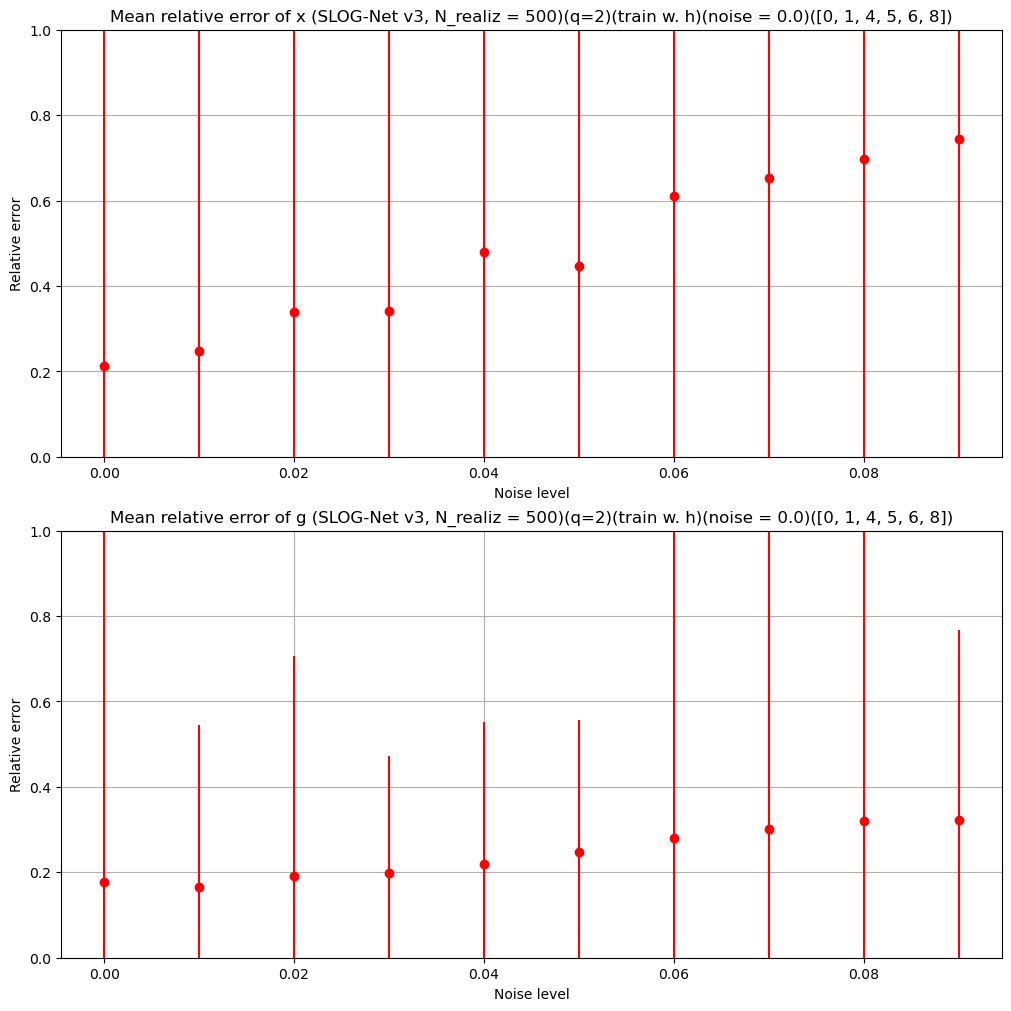

In [25]:
if model_number == 0:
    comment = '(SLOG-Net v1, N_realiz = '+str(N_realiz)+ ')'
elif model_number == 1:
    comment = '(SLOG-Net v3, N_realiz = '+str(N_realiz)+ ')'
else:
    comment = '(Unknown)'
comment_additional = '(q=' + str(q) + ')(train w. h)(noise = 0.0)'
# comment_additional = '(train w. g)'
comment = comment + comment_additional + '('+ str(model_index) + ')'

fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True,figsize=(10,10))
N_noiseLvIndex = 10
axes[0].errorbar(noiseLvs[:N_noiseLvIndex],re_x_avg[:N_noiseLvIndex], yerr =re_x_std[:N_noiseLvIndex], fmt = 'ro')
axes[0].set_title('Mean relative error of x '+ comment)
axes[0].set_xlabel('Noise level')
axes[0].set_ylabel('Relative error')
axes[0].set_ylim([0,1.0])
axes[0].grid()
axes[1].errorbar(noiseLvs[:N_noiseLvIndex],re_g_avg[:N_noiseLvIndex], yerr =re_g_std[:N_noiseLvIndex], fmt = 'ro')
axes[1].set_title('Mean relative error of g '+ comment)
axes[1].set_xlabel('Noise level')
axes[1].set_ylabel('Relative error')
axes[1].set_ylim([0,1.0])
axes[1].grid()
plt.show()

saveDir_plots = os.path.join(saveDir_dropbox_root,'plots')
save_name = "fig_slognoise_n" + str(N_realiz) + '_' + print_date+ "_list_" + str(list_number) + "_model_" + str(model_number) + "_" + list_name + "_errorbar_v1.jpg"

saveDir_fig = os.path.join(saveDir_plots,save_name)
# fig.savefig("E:\\trainedModels\ig_N20bS40_K5_re_acc_rasterized_v2.eps", format='eps')
# fig.savefig("E:\\trainedModels\ig_N20bS40_K5_re_acc_v2.svg", format="svg",transparent=True)
fig.savefig(saveDir_fig,format='jpg')

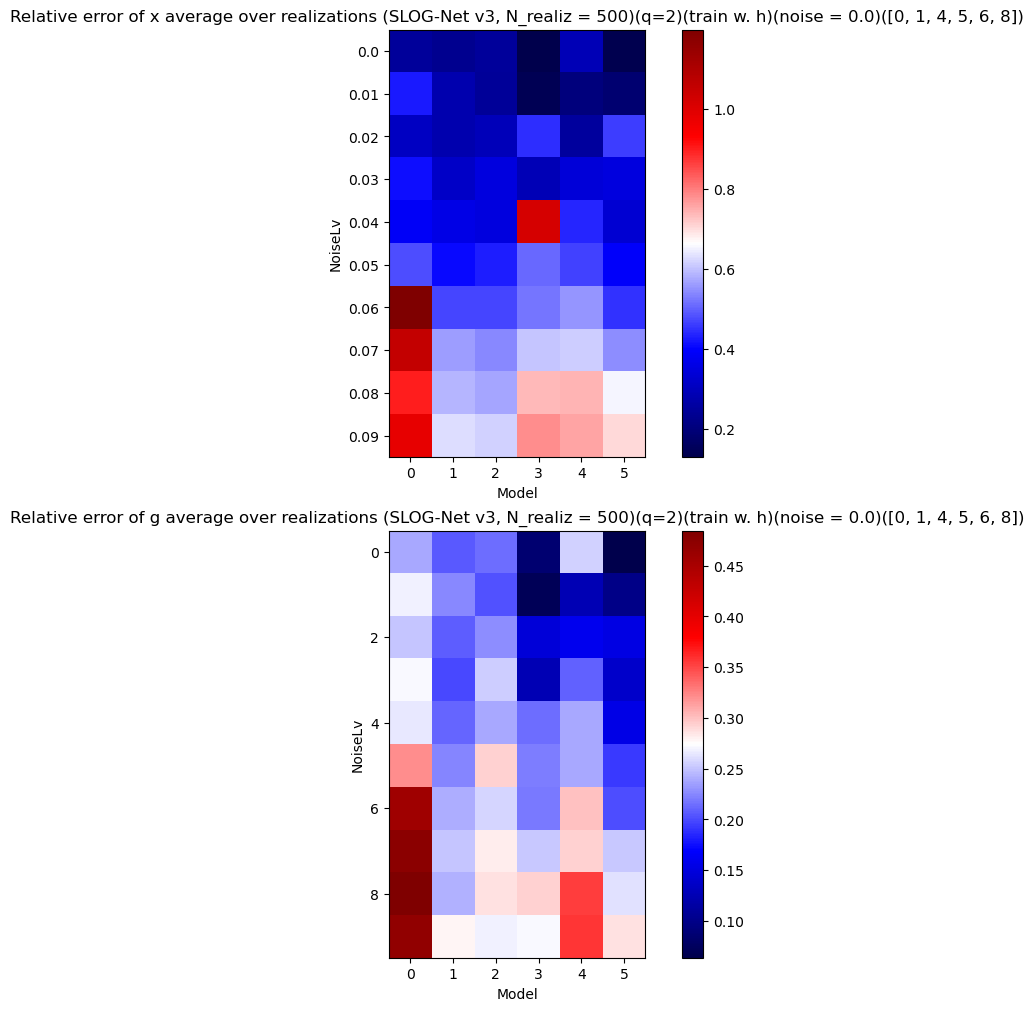

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True,figsize=(10,10))
# N_noiseLvIndex = 9
y_label_list = n0 + d_noiseLvs*np.arange(N_noiseLvIndex)
pos_1 = axes[0].imshow(np.mean(result_exp_rex_1,axis = 2), cmap=cm.seismic)
axes[0].set_title('Relative error of x average over realizations '+ comment)
axes[0].set_ylabel('NoiseLv')
axes[0].set_yticks(np.arange(N_noiseLvIndex))
axes[0].set_yticklabels([str(round(float(label), 2)) for label in y_label_list])
axes[0].set_xlabel('Model')
pos_2 = axes[1].imshow(np.mean(result_exp_reg_1,axis = 2), cmap=cm.seismic)
axes[1].set_title('Relative error of g average over realizations '+ comment)
axes[1].set_ylabel('NoiseLv')
axes[1].set_xlabel('Model')
fig.colorbar(pos_1, ax=axes[0], location='right', anchor=(1, 1), shrink=1.0)
fig.colorbar(pos_2, ax=axes[1], location='right', anchor=(1, 1), shrink=1.0)
plt.show()

saveDir_plots = os.path.join(saveDir_dropbox_root,'plots')
save_name = "fig_slognoise_n" + str(N_realiz) + '_' +print_date+ "_list_" + str(list_number) + "_model_" + str(model_number)+ "_" + list_name  + "_heatmap_v1.jpg"

saveDir_fig = os.path.join(saveDir_plots,save_name)
# fig.savefig("E:\\trainedModels\ig_N20bS40_K5_re_acc_rasterized_v2.eps", format='eps')
# fig.savefig("E:\\trainedModels\ig_N20bS40_K5_re_acc_v2.svg", format="svg",transparent=True)
fig.savefig(saveDir_fig,format='jpg')

Mean relative error for models

(10,)


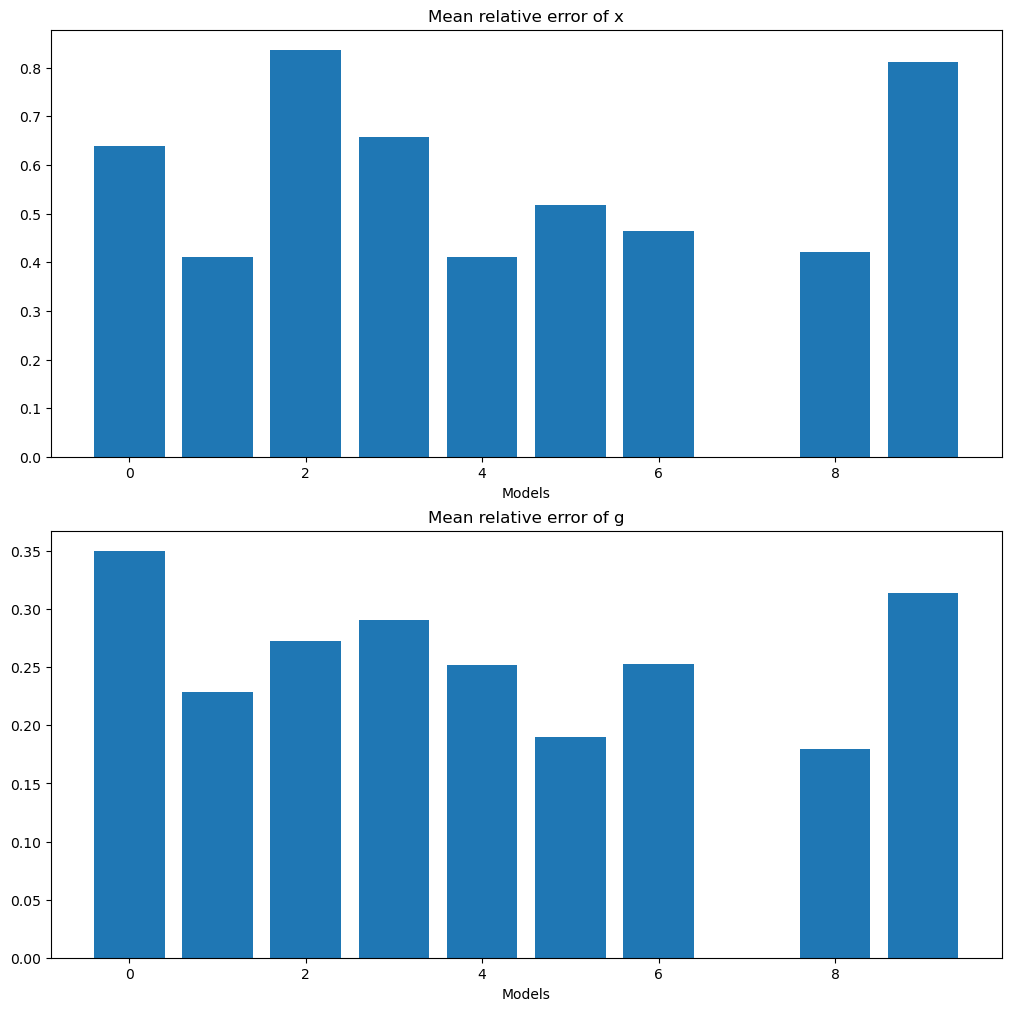

In [10]:
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
model = 0

re_x_avg = np.mean(np.mean(result_exp_rex, axis=0), axis=1)
re_g_avg = np.mean(np.mean(result_exp_reg, axis=0), axis=1)
print(re_x_avg.shape)
fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True,figsize=(10,10))
# axes[0].scatter(np.array(range(N_noiseLvs)),re_x_avg)
# axes[0].set_title('Mean relative error of x')
# axes[1].scatter(np.array(range(N_noiseLvs)),re_g_avg)
# axes[1].set_title('Mean relative error of g')

axes[0].bar(np.array(range(N_model)),re_x_avg)
axes[0].set_title('Mean relative error of x')
axes[0].set_xlabel('Models')
axes[1].bar(np.array(range(N_model)),re_g_avg)
axes[1].set_title('Mean relative error of g')
axes[1].set_xlabel('Models')
# n_realiz = 9
# axes[0].bar(np.array(range(N_realiz)),result_re_x[:,n_realiz])
# axes[0].set_title('Mean relative error of x')
# axes[1].bar(np.array(range(N_realiz)),result_re_g[:,n_realiz])
# axes[1].set_title('Mean relative error of g')
plt.show()